<a href="https://colab.research.google.com/github/ArhurK/P7_Data_Scientist_implentez_un_modele_de_scoring/blob/main/P7_Data_Scientist_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connection à Kaggle et téléchargement du dossier zip

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arthurkiehl","key":"13acb8548a6c7feacba1276076fa779d"}'}

In [ ]:
# !pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c home-credit-default-risk

100% 687M/688M [00:30<00:00, 26.4MB/s]
100% 688M/688M [00:30<00:00, 23.8MB/s]


## Extraction du dossier zip

In [5]:
import os
print(os.getcwd())

/content


In [6]:
import zipfile

# Sélection du fichier zip
zip_file_name = "home-credit-default-risk.zip"

# On définit le working directory
working_directory = "/content"


# Dézipper le fichier
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(working_directory)  # Extrayez le contenu du fichier zip dans le working directory


# Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_col_desc = pd.read_csv('HomeCredit_columns_description.csv', sep=",", encoding='latin1')
df_col_desc.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [ ]:
df_col_desc[['Table','Row','Description']]

,Table,Row,Description
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...,...
214,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...
216,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...


In [ ]:
df_ap = pd.read_csv('application_train.csv')

In [ ]:
df_ap.shape

(307511, 122)

In [ ]:
df_ap['OCCUPATION_TYPE'].value_counts()
# Quand NAn == Unknown ? Peut-être une info pertinante ? pk ne pas communiquer son métier ?

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
df_ap['EXT_SOURCE_2'].value_counts() # Data Leakage ?

0.285898    721
0.262258    417
0.265256    343
0.159679    322
0.265312    306
           ... 
0.004725      1
0.257313      1
0.282030      1
0.181540      1
0.267834      1
Name: EXT_SOURCE_2, Length: 119831, dtype: int64

In [ ]:
df_ap.isna().mean().sort_values(ascending=False).head(50)#[49:70]


COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MO

In [ ]:
print('Nombre de colonnes > 45 % de valeurs manquantes : ')
print(df_ap[df_ap.columns[df_ap.isna().mean() > 0.45]].shape[1])

Nombre de colonnes > 45 % de valeurs manquantes : 
49


In [ ]:
# A quoi correspondent ces données manquantes ?
col_na = df_ap[df_ap.columns[df_ap.isna().mean() > 0.45]].columns
# col_na.tolist()
df_col_desc.loc[
    df_col_desc['Row'].isin(col_na),
    ['Row','Description']
]
# Données sur habitations
# Est ce que le fait de ne pas avoir d'information sur le lieu d'habitation est une info ?
# 65 % NA OWN_CAR_AGE ==> client avec Na ou sans voiture ?
# FLAG_OWN_CAR ==> si client a une voiture ou non

,Row,Description
21,OWN_CAR_AGE,Age of client's car
41,EXT_SOURCE_1,Normalized score from external data source
44,APARTMENTS_AVG,Normalized information about building where th...
45,BASEMENTAREA_AVG,Normalized information about building where th...
46,YEARS_BEGINEXPLUATATION_AVG,Normalized information about building where th...
47,YEARS_BUILD_AVG,Normalized information about building where th...
48,COMMONAREA_AVG,Normalized information about building where th...
49,ELEVATORS_AVG,Normalized information about building where th...
50,ENTRANCES_AVG,Normalized information about building where th...
51,FLOORSMAX_AVG,Normalized information about building where th...


In [ ]:
df_col_desc.loc[
    ~df_col_desc['Row'].isin(col_na),
    ['Row','Description']
]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was su...
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,AMT_INSTALMENT,What was the prescribed installment amount of ...


# Feature Engineering
  From AGUIAR's kaggle
  link : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [7]:
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        # del bureau
        # gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        # del prev
        # gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        # del pos
        # gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        # del ins
        # gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        # del cc
    return df
        # gc.collect()
        # return df
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

# if __name__ == "__main__":
#     submission_file_name = "submission_kernel02.csv"
#     with timer("Full model run"):
#         main()

In [8]:
df = main(debug=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 24s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 12s
Installments payments df shape: (339587, 26)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s


In [9]:
df.to_pickle('df_P7_Scoring.plk')

# Modélisation

In [ ]:
# df = pd.read_pickle('df_P7_Scoring.plk')
# pd.read_pickle('df_P7_Scoring.plk')

In [10]:
df.shape

(356251, 798)

In [11]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.shape

(356251, 798)

In [12]:
df['TARGET'].value_counts(normalize =True)

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64

In [13]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [14]:
train_df['TARGET'].value_counts(normalize=True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

In [15]:
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold


In [17]:
train_df['TARGET'].value_counts(normalize=True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

In [18]:
# Train test split

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

X, y =  train_df[feats].copy(), train_df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Déséquilibre des classes
class_weight = {0: 0.08, 1: 0.91}

# Créez un dataset Light GBM pour l'ensemble d'entraînement
# train_data = lgb.Dataset(X_train, label= y_train)

# Pénalité plus élevée pour la classe positive (FN plus coûteux)
# class_weight = {0: 0.08, 1: 0.91}

In [97]:
from sklearn.metrics import make_scorer

# Définition d'une fonction de métrique personnalisée
def custom_metric(y_true, y_pred, seuil=.5):
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true,(y_pred>seuil).astype('int')).ravel()

    # Pénalisation des faux négatifs (FN) en multipliant par 2
    penalty = 10.0

    # Calcul de la métrique personnalisée
    custom_score = ((penalty * fn) + fp) /(tp+fn+fp+tn) #/ (tp + fp)

    return custom_score

# Création d'une fonction de score personnalisée avec make_scorer
custom_scorer = make_scorer(custom_metric, greater_is_better=True)

# Calcul du score personnalisé
# score = custom_scorer(y_true=y_test, y_pred=y_pred)

# print("Score personnalisé:", score)

# custom_metric(y_true=y_test,y_pred=y_pred)

# Dummy Classifier

In [101]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle DummyClassifier
    clf = DummyClassifier()
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score}")

Score de validation pour le pli 1: 0.9183603785242757
Score de validation pour le pli 2: 0.9207017657962343
Score de validation pour le pli 3: 0.9178549942277361
Score de validation pour le pli 4: 0.9204728378400351
Score de validation pour le pli 5: 0.9189606673062226
Moyenne des scores de validation sur les 5 plis : 0.9192701287389008


In [102]:
prediction_proba_dummy= np.concatenate(preds)
trues_proba = np.concatenate(trues)
custom_metric(y_true=trues_proba,y_pred=prediction_proba_dummy[:,1])

0.8072986956394489

In [109]:
print(classification_report(trues_proba, (prediction_proba_dummy[:,1] > 0.5).astype(int)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.00      0.00      0.00     24825

    accuracy                           0.92    307507
   macro avg       0.46      0.50      0.48    307507
weighted avg       0.85      0.92      0.88    307507



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Baseline cv no classe weights

In [110]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle LightGBM
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score}")

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.371050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99586
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080502 -> initscore=-2.435540
[LightGBM] [Info] Start training from score -2.435540
[LightGBM] [Info] Number of positive: 19948, number of negative: 226057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.181549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081088 -> initscore=-2.427658
[LightGBM] [Info] Start training from score -2.427658
[Lig

In [111]:
prediction_proba_baseline = np.concatenate(preds)
trues_proba = np.concatenate(trues)
custom_metric(y_true=trues_proba,y_pred=prediction_proba_baseline[:,1])

0.7766359790183638

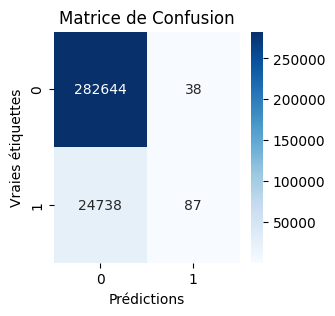

In [112]:
def matrice_conf_plot(y_test, y_pred, seuil):
  from sklearn.metrics import confusion_matrix
  conf_matrix = confusion_matrix(y_test, (y_pred[:,1] > seuil).astype(int))
  # Affichez la matrice de confusion
  plt.figure(figsize=(3, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies étiquettes')
  plt.title('Matrice de Confusion')
  return plt.show()

matrice_conf_plot(y_test = trues_proba, y_pred = prediction_proba_baseline, seuil = .7)

In [113]:
y_pred = prediction_proba_baseline[:,1]
# y_test = trues_proba

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.63      0.01      0.03     24825

    accuracy                           0.92    307507
   macro avg       0.77      0.51      0.49    307507
weighted avg       0.90      0.92      0.88    307507

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.70      0.00      0.01     24825

    accuracy                           0.92    307507
   macro avg       0.81      0.50      0.48    307507
weighted avg       0.90      0.92      0.88    307507

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.88      0.00      0.00     24825

    accuracy                           0.92    307507
   macro avg       0.90      0.50      0.48    307507
weighted avg       0.92      0.92      0.88    307507



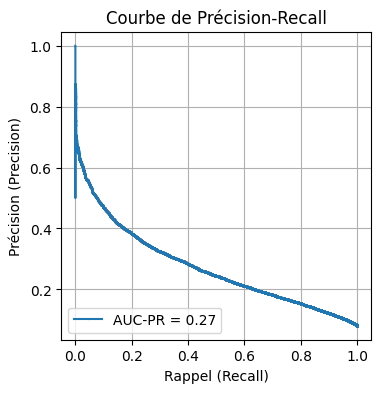

In [114]:
def courbe_precision_recall(y_test,y_pred):
  # Calculer la courbe de précision-recall
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

  # Calculer l'aire sous la courbe de précision-recall (AUC-PR)
  auc_pr = average_precision_score(y_test, y_pred[:,1])

  # Tracer la courbe de précision-recall
  plt.figure(figsize=(4, 4))
  plt.plot(recall, precision, marker='.', markersize=0.1)
  plt.xlabel('Rappel (Recall)')
  plt.ylabel('Précision (Precision)')
  plt.title('Courbe de Précision-Recall')
  plt.legend([f'AUC-PR = {auc_pr:.2f}'], loc='lower left')
  plt.grid(True)
  return plt.show()

courbe_precision_recall(y_test=trues_proba,y_pred=prediction_proba_baseline)

# I. validation croisée d'un modèle lightgbm avec class_weights

In [115]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle LightGBM avec les poids de classe
    clf = lgb.LGBMClassifier(class_weight=class_weight)
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score}")

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.050809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99586
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498969 -> initscore=-0.004122
[LightGBM] [Info] Start training from score -0.004122
[LightGBM] [Info] Number of positive: 19948, number of negative: 226057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.399827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500940 -> initscore=0.00

In [116]:
prediction_proba_weights = np.concatenate(preds)
trues_proba = np.concatenate(trues)
custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1])

0.49229123239470973

In [98]:
# Faire par seuil !
custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1])

0.49229123239470973

In [59]:
prediction_proba_weights[:,1]

array([0.80546189, 0.3434904 , 0.10055273, ..., 0.44397284, 0.29954529,
       0.50338548])

In [117]:
y_pred = prediction_proba_weights[:,1]

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred > 0.4).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.5).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75    282682
         1.0       0.15      0.80      0.26     24825

    accuracy                           0.63    307507
   macro avg       0.56      0.71      0.50    307507
weighted avg       0.91      0.63      0.71    307507

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83    282682
         1.0       0.19      0.69      0.29     24825

    accuracy                           0.73    307507
   macro avg       0.58      0.71      0.56    307507
weighted avg       0.90      0.73      0.79    307507

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89    282682
         1.0       0.23      0.55      0.32     24825

    accuracy                           0.81    307507
   macro avg       0.59      0.69      0.61    307507
weighted avg       0.90      0.81      0.85    307507

              preci

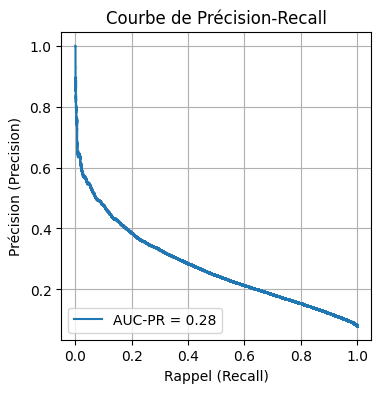

In [63]:
def courbe_precision_recall(y_test,y_pred):
  # Calculer la courbe de précision-recall
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

  # Calculer l'aire sous la courbe de précision-recall (AUC-PR)
  auc_pr = average_precision_score(y_test, y_pred)

  # Tracer la courbe de précision-recall
  plt.figure(figsize=(4, 4))
  plt.plot(recall, precision, marker='.', markersize=0.1)
  plt.xlabel('Rappel (Recall)')
  plt.ylabel('Précision (Precision)')
  plt.title('Courbe de Précision-Recall')
  plt.legend([f'AUC-PR = {auc_pr:.2f}'], loc='lower left')
  plt.grid(True)
  return plt.show()

courbe_precision_recall(trues_proba,y_pred)

In [ ]:
# # Calculer le score F1 pour chaque seuil
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
# # thresholds = f1_scores[:-1]
# # Tracer la courbe F1-score en fonction du seuil
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, f1_scores, marker='.')
# plt.xlabel('Seuil de Classification')
# plt.ylabel('Score F1')
# plt.title('Courbe F1-score en fonction du seuil de classification')
# plt.grid(True)
# plt.show()

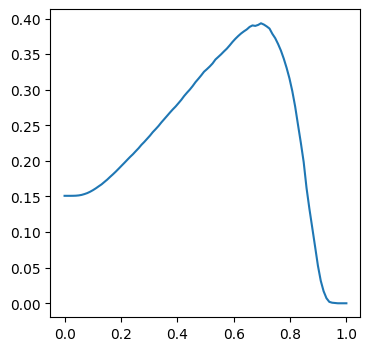

Valeur max de f1_score :  0.3933316408563934


In [43]:
# Définition des seuils de classification pour lesquels on va calculer
# les f1 scores
threshold_array = np.linspace(0, 1, 100)
f1_list = []

for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (y_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = f1_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    f1_list.append(f1_threshold)
plt.figure(figsize=(4,4))
plt.plot(threshold_array, f1_list)
plt.show()
print('Valeur max de f1_score : ',max(f1_list))

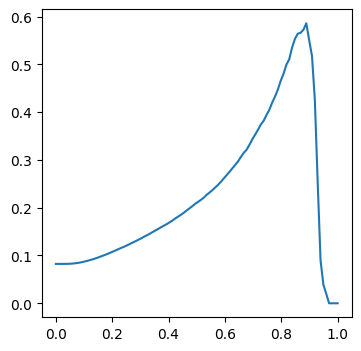

Valeur max de f_beta_score :  0.5858500585496037


In [44]:
# Définition des seuils de classification pour lesquels on va calculer
# les f1 scores
threshold_array = np.linspace(0, 1, 100)
f1_list = []

for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (y_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = fbeta_score(
        y_true=y_test, y_pred=label_pred_threshold,
        beta =0.1)

    f1_list.append(f1_threshold)
plt.figure(figsize=(4,4))
plt.plot(threshold_array, f1_list)
plt.show()
print('Valeur max de f_beta_score : ',max(f1_list))

In [69]:
y_pred

array([0.80546189, 0.3434904 , 0.10055273, ..., 0.44397284, 0.29954529,
       0.50338548])

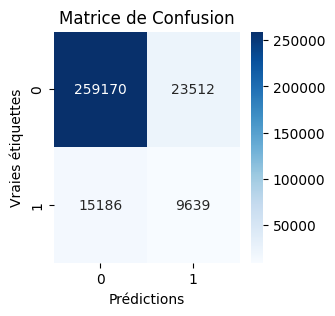

In [96]:

matrice_conf_plot(
    y_test = trues_proba,
    y_pred = prediction_proba_weights,
    seuil = .7
    )

In [92]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# def matrice_confusion_plot(y_test, y_pred, seuil=0.5, figsize=(4,4)):
#     # Appliquer un seuil aux probabilités pour obtenir des prédictions binaires
#     y_pred_binaire = (y_pred >= seuil).astype(int)

#     # Calculer la matrice de confusion
#     cm = confusion_matrix(y_test, y_pred_binaire)

#     # Afficher la matrice de confusion sous forme de tableau
#     print("Matrice de confusion :")
#     print(cm)

#     # Créer une figure avec la taille spécifiée
#     plt.figure(figsize=figsize)

#     # Tracer la matrice de confusion
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap=plt.cm.Blues, values_format="d")
#     plt.title("Matrice de confusion")
#     plt.show()

# # Appeler la fonction avec vos données
# matrice_confusion_plot(y_test=trues_proba, y_pred=prediction_proba_weights[:, 1], seuil=0.5)

In [83]:
# matrice_conf_plot(y_test=trues_proba,y_pred=prediction_proba_weights[:,1],seuil = 0.5)

# SMOTE
  N'accepte pas les NAn

In [84]:
# SMOTE
# from imblearn.over_sampling import SMOTE

In [ ]:
# sm = SMOTE(random_state =122)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Sous échantillonnage

In [118]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Comptage positif/négatif y_train
    n_0 = np.sum(y_train==0)
    n_1 = np.sum(y_train==1)

    # Sélection par index
    index_1 = np.where(y_train==1)[0]
    index_0 = np.where(y_train==0)[0]

    # Echantillonnage
    index = np.random.choice(index_0, size = n_1, replace = False)

    X_train = np.concatenate([X_train.iloc[index,:],X_train.iloc[index_1,:]], axis=0)
    y_train = np.concatenate([y_train.iloc[index],y_train.iloc[index_1]], axis=0)

    # Créer et entraîner le modèle LightGBM avec les poids de classe
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score}")

[LightGBM] [Info] Number of positive: 19804, number of negative: 19804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93128
[LightGBM] [Info] Number of data points in the train set: 39608, number of used features: 773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19948, number of negative: 19948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93212
[LightGBM] [Info] Number of data points in the train set: 39896, number of used features: 774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19773, number of negative: 19773
[LightGBM] [Info] Auto-choosing col-wise multi-

In [119]:
prediction_proba_under = np.concatenate(preds)
trues_proba = np.concatenate(trues)
custom_metric(y_true=trues_proba,y_pred=prediction_proba_under[:,1])

0.5010357487797026

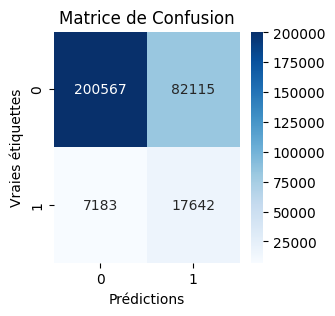

In [87]:
matrice_conf_plot(y_test=trues_proba, y_pred = prediction_proba_under, seuil=.5)

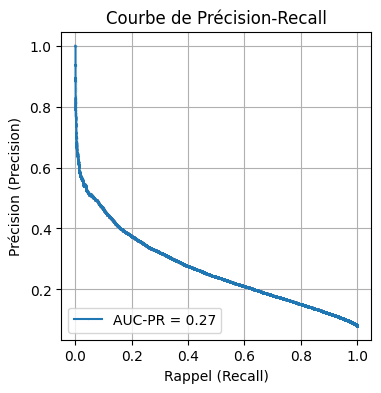

In [90]:
courbe_precision_recall(y_test=trues_proba,y_pred=prediction_proba_under[:,1])

In [93]:
y_pred_under = prediction_proba_under[:,1]

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred_under > 0.4).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.5).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.58      0.73    282682
         1.0       0.15      0.82      0.25     24825

    accuracy                           0.60    307507
   macro avg       0.56      0.70      0.49    307507
weighted avg       0.91      0.60      0.69    307507

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    282682
         1.0       0.18      0.71      0.28     24825

    accuracy                           0.71    307507
   macro avg       0.57      0.71      0.55    307507
weighted avg       0.90      0.71      0.77    307507

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88    282682
         1.0       0.22      0.58      0.31     24825

    accuracy                           0.80    307507
   macro avg       0.59      0.70      0.60    307507
weighted avg       0.90      0.80      0.83    307507

              preci

# Brouillon

In [ ]:
# # Faites des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# # Évaluez le modèle
print(classification_report(y_test, (y_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56481
         1.0       0.68      0.02      0.04      5021

    accuracy                           0.92     61502
   macro avg       0.80      0.51      0.50     61502
weighted avg       0.90      0.92      0.88     61502



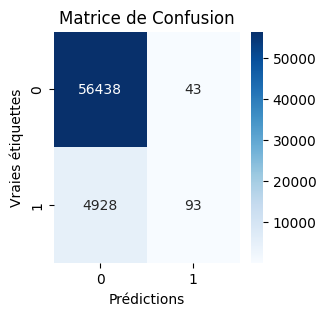

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
# Affichez la matrice de confusion
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
pd.Series(y_pred).isna().sum(),pd.Series(y_test).isna().mean()

(0, 0.0)

In [ ]:
# # # Définissez les paramètres du modèle Light GBM
# params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "boosting_type": "gbdt",
#     # "is_unbalance": True,
#     "num_leaves": 31,
#     "learning_rate": 0.05,
# }
# # Créez un dataset Light GBM pour l'ensemble d'entraînement
# train_data = lgb.Dataset(X_train, label=y_train)

# # # Entraînez le modèle Light GBM
# model = lgb.train(params = params, train_set = train_data, num_boost_round=100)

In [ ]:
# # Créer un classificateur HistGradientBoostingClassifier
# clf = HistGradientBoostingClassifier()

# # Entrainer le modèle
# clf.fit(X_train, y_train)

# # Calculer la précision sur les données de test
# score = clf.score(X_test, y_test)

# # Afficher la précision
# print("Précision :", score)

Précision : 0.9191245813144288


In [ ]:
# # Créer un classificateur LightGBM
# clf = LGBMClassifier(n_jobs=-1)

# # Définir l'espace de recherche
# params = {
#     "objective": ["binary", "tweedie"],
#     "n_estimators": [100, 200, 300],
#     "learning_rate": [0.1, 0.05, 0.01],
#     "max_depth": [3, 5, 7],
#     "min_child_samples": [5, 10, 15],
#     'early_stopping_rounds' : [5]
# }

# # Ajouter early stopping
# # params["early_stopping_rounds"] = 5
# # params["early_stopping_metric"] = "accuracy"

# # Créer un objet GridSearchCV
# gscv = GridSearchCV(clf, params, cv=5, scoring="accuracy")

# # Entrainer le modèle
# gscv.fit(X_train, y_train)

# # Afficher les meilleurs paramètres
# print(gscv.best_params_)

In [ ]:
# # Créer un modèle HistGradientBoostingClassifier
# clf = HistGradientBoostingClassifier(random_state=42)

# # Effectuer une validation croisée (cross-validation) avec 5 plis
# scores = cross_val_score(clf, X_train, y_train, cv=5)

# # Entraîner le modèle sur l'ensemble d'entraînement complet
# clf.fit(X_train, y_train)

# # Évaluer les performances du modèle sur l'ensemble de test
# test_score = clf.score(X_test, y_test)

# # Afficher les scores de validation croisée
# print("Scores de validation croisée (5 plis):", scores)
# print("Moyenne des scores de validation croisée:", np.mean(scores))
# print("Performance sur l'ensemble de test:", test_score)

Scores de validation croisée (5 plis): [0.92004228 0.9203878  0.91945286 0.92036747 0.92028617]
Moyenne des scores de validation croisée: 0.9201073148919738
Performance sur l'ensemble de test: 0.9192709180189262
